In [1]:
import pandas as pd
import os
from plotnine import *  # type: ignore
import numpy as np

# Single 
- one dda function (single), calls actions on an external actor, waits for a
  response and returns
- self triggered through delayed_casts


- plot the dataplane stat of dda sidecar on the same timeline graph

In [ ]:
filename = 'data/dda_application_logs.csv'
df = pd.read_csv(filename)
df = df[df['target'] != 'func']

# timestamp is in seconds (unix epoch time)
df["timestamp"] = df["timestamp"] * 1_000_000_000  # convert to nanoseconds
df["timestamp"] = df["timestamp"].astype("int")
df["timestamp"] = df["timestamp"] - df["timestamp"].min()
print(df.head())

# Function durations during DDA chain execution

In [ ]:
func_events = df[df['target'].isin(['function:start', 'function:end'])].copy()

func_pivot = func_events.pivot_table(
    index=['identifier', 'value'], 
    columns='target', 
    values='timestamp', 
    aggfunc='first'
).reset_index()

func_pivot['duration'] = func_pivot['function:end'] - func_pivot['function:start']
func_pivot['duration'] = func_pivot['duration'] / 1_000_000  # convert to milis

func_durations = func_pivot.dropna(subset=['function:start', 'function:end']).copy()

# Count function:start events without corresponding function:end
start_without_end = func_pivot[func_pivot['function:end'].isna() & func_pivot['function:start'].notna()]
end_without_start = func_pivot[func_pivot['function:start'].isna() & func_pivot['function:end'].notna()]

print("Function execution durations:")
print(func_durations.head(10))
print(f"\nSummary statistics:")
print(f"Mean duration: {func_durations['duration'].mean():.3f} ms")
print(f"Std deviation: {func_durations['duration'].std():.3f} ms")
print(f"Min duration: {func_durations['duration'].min():.3f} ms")
print(f"Max duration: {func_durations['duration'].max():.3f} ms")

print(f"\nIncomplete function executions:")
print(f"functions under 150ms: {len(func_durations[func_durations['duration'] < 150])}")
print(f"function:start without function:end: {len(start_without_end)}")
print(f"function:end without function:start: {len(end_without_start)}")
print(f"Total complete function executions: {len(func_durations)}")

if len(start_without_end) > 0:
    print(f"\nSample function:start events without corresponding function:end:")
    print(start_without_end[['identifier', 'value', 'function:start']].head())

# Workflow duration during DDA chain execution

In [ ]:
# show all workflows on the same plot, different colors
# add legend for workflow length
filename = 'data/dda_application_logs.csv'
df = pd.read_csv(filename)
df = df[df['target'] != 'func']

# timestamp is in seconds (unix epoch tim)
df["timestamp"] = df["timestamp"] * 1_000_000_000  # convert to nanoseconds
df["timestamp"] = df["timestamp"].astype("int")
df["timestamp"] = df["timestamp"] - df["timestamp"].min()

# sort by timestamp
df = df.sort_values(by='timestamp')
workflow_events = df[df['target'].isin(['workflow:start', 'workflow:end'])].copy()
# for workflows that have start and end, compute duration; correlated by the value column
workflow_pivot = workflow_events.pivot_table(
    index=['value'], # only value is the correlation key for workflows
    columns='target', 
    values='timestamp', 
    aggfunc='first'
).reset_index()
workflow_pivot['duration'] = workflow_pivot['workflow:end'] - workflow_pivot['workflow:start']
workflow_pivot['duration'] = workflow_pivot['duration'] / 1_000_000  # convert to milliseconds
workflow_durations = workflow_pivot.dropna(subset=['workflow:start', 'workflow:end']).copy()

# Pre-optimization (blocking DDA)

File: 5.csv
  Number of workflows: 421
  Mean duration: 566.62 ms
  Std duration: 32.35 ms
  Min duration: 340.49 ms
  Max duration: 649.54 ms
File: 10.csv
  Number of workflows: 181
  Mean duration: 1128.67 ms
  Std duration: 47.39 ms
  Min duration: 1018.68 ms
  Max duration: 1243.45 ms
File: 7.csv
  Number of workflows: 309
  Mean duration: 793.06 ms
  Std duration: 31.60 ms
  Min duration: 582.26 ms
  Max duration: 902.29 ms
File: 3.csv
  Number of workflows: 693
  Mean duration: 339.53 ms
  Std duration: 25.76 ms
  Min duration: 19.37 ms
  Max duration: 408.15 ms
File: 1.csv
  Number of workflows: 2097
  Mean duration: 112.94 ms
  Std duration: 14.90 ms
  Min duration: 17.57 ms
  Max duration: 167.55 ms


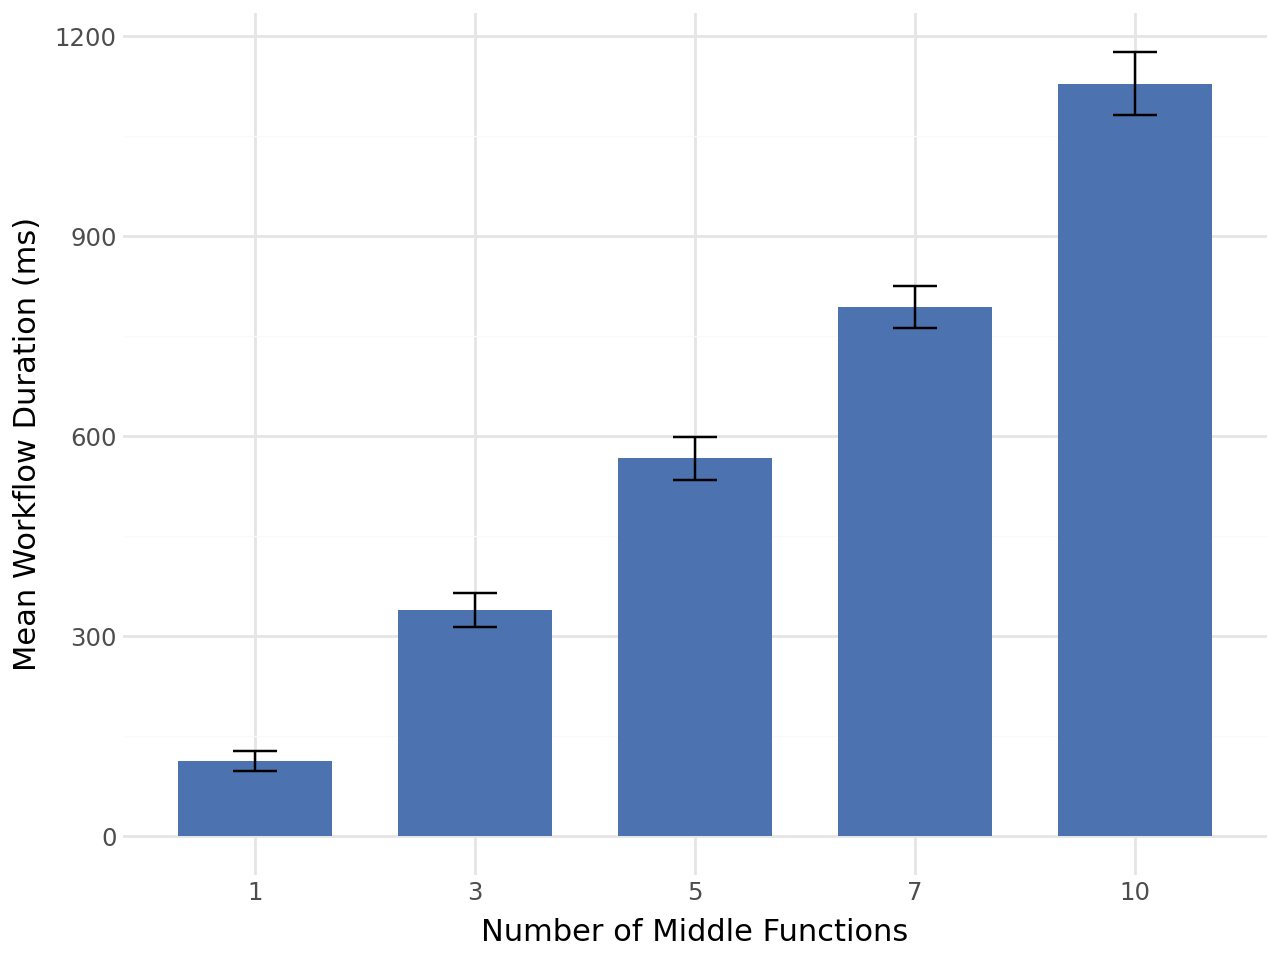

In [2]:
# cumulative plot
dirname = "plots_data/pre"
all_workflow_durations = []

for fname in os.listdir(dirname):
    if fname.endswith('.csv'):
        fpath = os.path.join(dirname, fname)
        df_tmp = pd.read_csv(fpath)
        df_tmp = df_tmp[df_tmp['target'] != 'func']
        df_tmp["timestamp"] = df_tmp["timestamp"] * 1_000_000_000  # convert to nanoseconds
        df_tmp["timestamp"] = df_tmp["timestamp"].astype("int")
        df_tmp["timestamp"] = df_tmp["timestamp"] - df_tmp["timestamp"].min()
        workflow_events = df_tmp[df_tmp['target'].isin(['workflow:start', 'workflow:end'])].copy()

        workflow_pivot = workflow_events.pivot_table(
            index=['value', 'identifier'],
            columns='target',
            values='timestamp',
            aggfunc='first'
        ).reset_index()
        workflow_pivot['duration'] = workflow_pivot['workflow:end'] - workflow_pivot['workflow:start']
        workflow_pivot['duration'] = workflow_pivot['duration'] / 1_000_000  # convert to milliseconds
        # Drop negative durations
        workflow_pivot = workflow_pivot[workflow_pivot['duration'] >= 0]
        # Remove .csv suffix from filename
        workflow_pivot['middle_functions'] = fname.replace('.csv', '')
        workflow_pivot = workflow_pivot.dropna(subset=['workflow:start', 'workflow:end']).copy()
        workflow_pivot['duration'] = workflow_pivot['workflow:end'] - workflow_pivot['workflow:start']
        workflow_pivot['duration'] = workflow_pivot['duration'] / 1_000_000  # convert to milliseconds
        workflow_pivot = workflow_pivot.dropna(subset=['workflow:start', 'workflow:end']).copy()

        print(f"File: {fname}")
        print(f"  Number of workflows: {len(workflow_pivot)}")
        print(f"  Mean duration: {workflow_pivot['duration'].mean():.2f} ms")
        print(f"  Std duration: {workflow_pivot['duration'].std():.2f} ms")
        print(f"  Min duration: {workflow_pivot['duration'].min():.2f} ms")
        print(f"  Max duration: {workflow_pivot['duration'].max():.2f} ms")
        all_workflow_durations.append(workflow_pivot)

all_workflow_durations_df = pd.concat(all_workflow_durations, ignore_index=True)
summary_df = all_workflow_durations_df.groupby('middle_functions').agg(
    mean_duration=('duration', 'mean'),
    sd_duration=('duration', 'std')
).reset_index()
summary_df['middle_functions'] = summary_df['middle_functions'].astype(str)

(
    ggplot(summary_df, aes(x='middle_functions', y='mean_duration'))
    + geom_bar(stat='identity', fill='#4C72B0', width=0.7)
    + geom_errorbar(aes(ymin='mean_duration - sd_duration', ymax='mean_duration + sd_duration'), width=0.2)
    + labs(
        x='Number of Middle Functions',
        y='Mean Workflow Duration (ms)',
    )
    + theme_minimal()
    + scale_x_discrete(limits=sorted(summary_df['middle_functions'], key=lambda x: int(x)))
)


# Post optimization (non-blocking DDA)

File: 5.csv
  Number of workflows: 1679
  Mean duration: 176.37 ms
  Std duration: 22.96 ms
  Min duration: 112.71 ms
  Max duration: 270.50 ms
File: 10.csv
  Number of workflows: 1729
  Mean duration: 233.14 ms
  Std duration: 37.12 ms
  Min duration: 124.03 ms
  Max duration: 348.05 ms
File: 7.csv
  Number of workflows: 1555
  Mean duration: 195.92 ms
  Std duration: 32.13 ms
  Min duration: 108.22 ms
  Max duration: 378.00 ms
File: 3.csv
  Number of workflows: 1471
  Mean duration: 161.12 ms
  Std duration: 12.88 ms
  Min duration: 111.94 ms
  Max duration: 208.04 ms
File: 1.csv
  Number of workflows: 447
  Mean duration: 109.12 ms
  Std duration: 12.19 ms
  Min duration: 102.17 ms
  Max duration: 149.12 ms


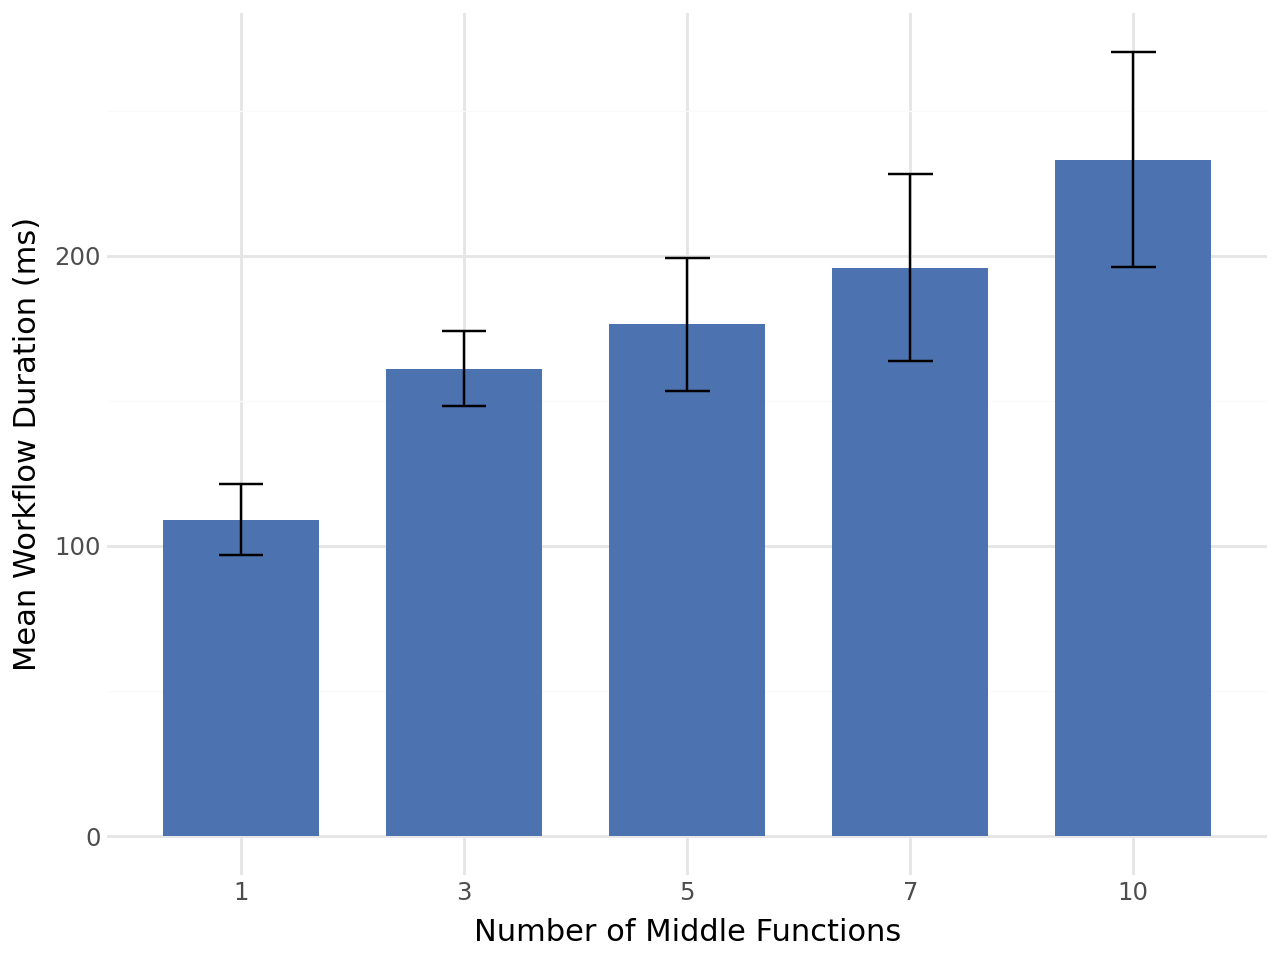

In [25]:
# cumulative plot
dirname = "plots_data/post"
all_workflow_durations = []

for fname in os.listdir(dirname):
    if fname.endswith('.csv'):
        fpath = os.path.join(dirname, fname)
        df_tmp = pd.read_csv(fpath)
        df_tmp = df_tmp[df_tmp['target'] != 'func']
        df_tmp["timestamp"] = df_tmp["timestamp"] * 1_000_000_000  # convert to nanoseconds
        df_tmp["timestamp"] = df_tmp["timestamp"].astype("int")
        df_tmp["timestamp"] = df_tmp["timestamp"] - df_tmp["timestamp"].min()
        workflow_events = df_tmp[df_tmp['target'].isin(['workflow:start', 'workflow:end'])].copy()

        workflow_pivot = workflow_events.pivot_table(
            index=['value', 'identifier'],
            columns='target',
            values='timestamp',
            aggfunc='first'
        ).reset_index()
        workflow_pivot['duration'] = workflow_pivot['workflow:end'] - workflow_pivot['workflow:start']
        workflow_pivot['duration'] = workflow_pivot['duration'] / 1_000_000  # convert to milliseconds
        # Drop negative durations
        workflow_pivot = workflow_pivot[workflow_pivot['duration'] >= 0]
        # Remove .csv suffix from filename
        workflow_pivot['middle_functions'] = fname.replace('.csv', '')
        workflow_pivot = workflow_pivot.dropna(subset=['workflow:start', 'workflow:end']).copy()
        workflow_pivot['duration'] = workflow_pivot['workflow:end'] - workflow_pivot['workflow:start']
        workflow_pivot['duration'] = workflow_pivot['duration'] / 1_000_000  # convert to milliseconds
        workflow_pivot = workflow_pivot.dropna(subset=['workflow:start', 'workflow:end']).copy()

        print(f"File: {fname}")
        print(f"  Number of workflows: {len(workflow_pivot)}")
        print(f"  Mean duration: {workflow_pivot['duration'].mean():.2f} ms")
        print(f"  Std duration: {workflow_pivot['duration'].std():.2f} ms")
        print(f"  Min duration: {workflow_pivot['duration'].min():.2f} ms")
        print(f"  Max duration: {workflow_pivot['duration'].max():.2f} ms")
        all_workflow_durations.append(workflow_pivot)

all_workflow_durations_df = pd.concat(all_workflow_durations, ignore_index=True)
summary_df = all_workflow_durations_df.groupby('middle_functions').agg(
    mean_duration=('duration', 'mean'),
    sd_duration=('duration', 'std')
).reset_index()
summary_df['middle_functions'] = summary_df['middle_functions'].astype(str)

(
    ggplot(summary_df, aes(x='middle_functions', y='mean_duration'))
    + geom_bar(stat='identity', fill='#4C72B0', width=0.7)
    + geom_errorbar(aes(ymin='mean_duration - sd_duration', ymax='mean_duration + sd_duration'), width=0.2)
    + labs(
        x='Number of Middle Functions',
        y='Mean Workflow Duration (ms)',
    )
    + theme_minimal()
    + scale_x_discrete(limits=sorted(summary_df['middle_functions'], key=lambda x: int(x)))
)
